# 

このノートブックでは、外生変数と内生変数、シンク変数を仮定し、さらに外生変数とシンク変数に離散的な順序変数が含まれる場合の因果探索の実施方法を説明する。

lingamパッケージに実装されたアルゴリズムは、基本的に離散変数が含まれたデータに適用することはできない。しかし外生変数やシンク変数に仮定した変数に離散変数が含まれる場合は、このノートブックで説明する工夫を取り入れることで、因果探索を実施することが可能になる。

## 準備

### ライブラリのインポート

このノートブックで使用するライブラリをインポートする。

In [28]:
import os
import shutil
import requests

import numpy as np
import pandas as pd
from scipy.special import expit
import semopy
import networkx as nx

from lingam import DirectLiNGAM
from lingam.utils import remove_effect
from lingam.utils import calculate_total_effect
from lingam.bootstrap import BootstrapResult
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.utils import check_array

from lingam.utils import make_dot
from lingam.utils import print_causal_directions
from lingam.utils import print_dagc
import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

### ソースコードのダウンロードと設定

このノートブックを実行するには、[ada_logistic_reg](https://github.com/cdt15/ada_logistic_reg) のソースコードのダウンロードと設定が必要となる。下記のコードを実行することでソースコードのダウンロードとインポートを実施できるが、別途Rのインストールや設定と、glmnetパッケージのインストールが必要となる。

In [2]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

dirname = "ada_log_reg"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

# define an interface like scikit-learn
class AdaptiveLogisticRegression:

    def fit(self, X, y):
        X = check_array(X)
        y = check_array(y, ensure_2d=False, dtype=int)
        
        X_ = np.concatenate([X, y.reshape(-1, 1)], axis=1)
        
        predictors = np.arange(len(X.T))
        target = X_.shape[1] - 1
        
        coef = predict_adaptive_logistic_regression(X_, predictors, target)
        
        self.coef_ = coef

### 乱数の設定

乱数の種を固定するための設定を行う。

In [3]:
np.random.seed(0)

## テストデータ

### 隣接行列

In [4]:
m = np.array([
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.043, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    [0.000, 1.727, 0.537, 0.000, 0.000, 0.000, 0.000, 0.000],
    [1.041, 0.911, 0.000, 0.427, 0.000, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 1.960, 0.691, 0.000, 0.000, 0.000],
    [0.000, 0.000, 0.000, 0.000, 0.000, 0.883, 1.385, 0.000],
])

names = [f"x{i}" for i in range(len(m))]
m = pd.DataFrame(m, columns=names, index=names)

m

,x0,x1,x2,x3,x4,x5,x6,x7
x0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
x3,0.000,1.043,0.000,0.000,0.000,0.000,0.000,0.0
x4,0.000,1.727,0.537,0.000,0.000,0.000,0.000,0.0
x5,1.041,0.911,0.000,0.427,0.000,0.000,0.000,0.0
x6,0.000,0.000,0.000,1.960,0.691,0.000,0.000,0.0
x7,0.000,0.000,0.000,0.000,0.000,0.883,1.385,0.0


この隣接行列を因果グラフとして描画した図は次の通り:

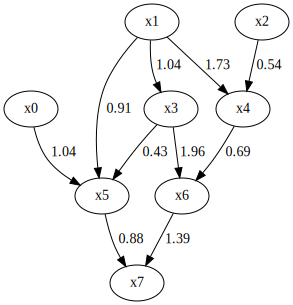

In [5]:
make_dot(m, lower_limit=0)

### データの生成

隣接行列に従ってデータを生成する。x1 と x7 を 0 または 1 の値を持つ離散的な順序変数とする。

In [6]:
# 設定
n_sample = 1000
discrete_indices = [0, 7]

# テストデータの初期化
X = np.zeros((len(m), n_sample))

# 因果順序に従ってデータを生成
for i in range(len(m)):
    if i not in discrete_indices:
        X[i] = m.iloc[i] @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = (expit(m.iloc[i] @ X) >= np.random.uniform(0, 1, size=n_sample)).astype(int)
X = pd.DataFrame(X.T, columns=names)

# 離散変数をintに、連続変数をfloatに変換
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)

データのヒストグラムは次の通り

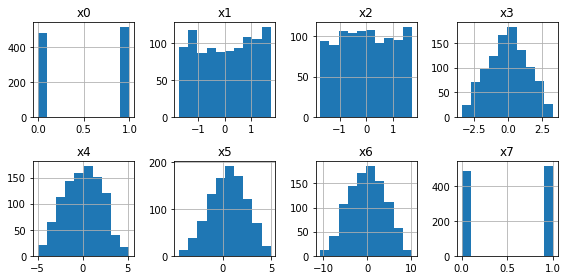

In [7]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

データ型は次の通り。

In [8]:
X.dtypes

x0      int64
x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7      int64
dtype: object

## 分析

作成したテストデータXから隣接行列を推定する。

### 変数を3つのセットに分類

データXの変数を、外生変数、内生変数、シンク変数の3種の変数集合に分類する。

In [9]:
exog_var_names = ["x0", "x1", "x2"]
endog_var_names = ["x3", "x4", "x5", "x6"]
sink_var_name = "x7"

因果グラフは次のようになる。

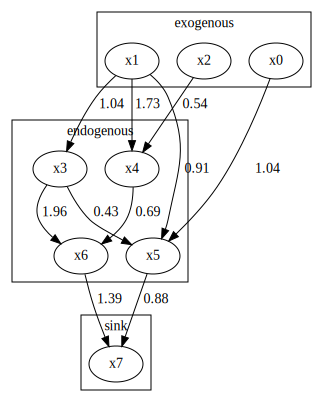

In [10]:
g = gv.Digraph()

cluster_names = ["exogenous", "endogenous", "sink"]

# add nodes
for cluster_name, var_names in zip(cluster_names, [exog_var_names, endog_var_names, [sink_var_name]]):
    # make subgraph
    with g.subgraph(name=f"cluster_{cluster_name}") as sub:
        for var_name in var_names:
            sub.node(var_name, var_name)
        sub.attr(label=f"{cluster_name}")

# add edges
for to_name, coefs in m.iterrows():
    for from_name, coef in coefs.items():
        if np.isclose(coef, 0):
            continue
        
        g.edge(from_name, to_name, label=f"{coef:.2f}")

g

### 分析の実行

データXと3つの変数名リストをもとに、内生変数とシンク変数の因果関係を分析する。

まずはデータXから外生変数の影響を削除する。

In [11]:
X_removed_exog = X.copy()

# 回帰により外生変数の効果を内生変数から取り除く
for endog_var_name in endog_var_names:
    # 回帰モデルの作成
    reg = LinearRegression()
    reg.fit(X[exog_var_names], X[endog_var_name])
    
    # 外生変数による効果の削除
    X_removed_exog[endog_var_name] = X[endog_var_name] - reg.predict(X[exog_var_names])

X_removed_exog = X_removed_exog.drop(exog_var_names, axis=1)

外生変数の影響を削除したデータの内生変数に対して因果探索を実施する。

In [12]:
cd_model = DirectLiNGAM()
cd_model.fit(X_removed_exog[endog_var_names])

cd_model.adjacency_matrix_

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.42269326, 0.        , 0.        , 0.        ],
       [1.9185075 , 0.66491191, 0.        , 0.        ]])

次に内生変数を説明変数としてシンク変数のモデルを推定する。シンク変数は離散変数であるためロジスティック回帰モデルを使用する。

In [13]:
sink_model = LogisticRegression(penalty=None)
sink_model.fit(X_removed_exog[endog_var_names], X_removed_exog[sink_var_name])

sink_model.coef_

array([[-0.05914499, -0.09792208,  0.31392752,  0.3289729 ]])

内生変数の隣接行列とシンク変数のモデルの係数をまとめて、ひとつの隣接行列にして、分析結果を得る。

In [14]:
adj = np.concatenate([cd_model.adjacency_matrix_, sink_model.coef_])
adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

cols = endog_var_names + [sink_var_name]
adj = pd.DataFrame(adj, columns=cols, index=cols)

adj

,x3,x4,x5,x6,x7
x3,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.000000,0.000000,0.000000,0.000000,0.0
x5,0.422693,0.000000,0.000000,0.000000,0.0
x6,1.918507,0.664912,0.000000,0.000000,0.0
x7,-0.059145,-0.097922,0.313928,0.328973,0.0


### 分析結果の可視化

因果グラフは次の通り。

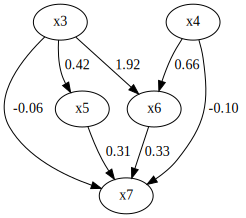

In [15]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

### 適合度による評価

推定した結果をSEMモデルと見なして適合度を計算する。

In [16]:
def calc_fit_indices(B, X):
    """ 隣接行列BとデータXから適合度を評価する。 """
    
    desc = ""
    for name, row in B.iterrows():
        var_model = []
        
        for name2, coef in row.items():
            if np.isclose(coef, 0):
                continue
            var_model.append(f"{coef} * {name2}")
        
        if len(var_model) == 0:
            continue
        
        var_model = f"{name} ~ " + " + ".join(var_model) + "\n"
        desc += var_model
    
    m = semopy.Model(desc)
    m.fit(X)
    stats = semopy.calc_stats(m)
    
    return stats

# exogenous variablesの効果を抜いたデータとシンク変数のデータを結合したデータで評価
X_eval = X_removed_exog.copy()
X_eval[sink_var_name] = X[sink_var_name]

fit_indices = calc_fit_indices(adj, X_eval)
fit_indices

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,12,12,1091.727363,0.0,1952.176012,0.44349,0.440764,0.440764,0.440764,0.44349,0.300112,3.816545,18.539811,1.091727


### シンク変数のモデルの枝刈り

推定した結果を真の因果グラフと見比べると、x7に向かうエッジが余分に推定されていることが分かる。シンク変数のモデルとして、LogsticRegression の代わりに AdaptiveLogisticRegression を使用することで、この問題を解決することができる。

In [17]:
sink_model2 = AdaptiveLogisticRegression()
sink_model2.fit(X_removed_exog[endog_var_names], X_removed_exog[sink_var_name])

sink_model2.coef_

array([[0.        , 0.        , 0.29385481, 0.29029779]])

先ほどと同様にして内生変数の隣接行列とシンク変数のモデルの係数をひとつの隣接行列にする。

In [18]:
adj = np.concatenate([cd_model.adjacency_matrix_, sink_model2.coef_])
adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

cols = endog_var_names + [sink_var_name]
adj = pd.DataFrame(adj, columns=cols, index=cols)

adj

,x3,x4,x5,x6,x7
x3,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.000000,0.000000,0.000000,0.000000,0.0
x5,0.422693,0.000000,0.000000,0.000000,0.0
x6,1.918507,0.664912,0.000000,0.000000,0.0
x7,0.000000,0.000000,0.293855,0.290298,0.0


因果グラフは次の通り。

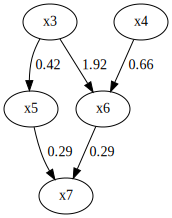

In [19]:
make_dot(adj, labels=adj.columns.tolist(), lower_limit=0.0)

真の因果グラフと見比べることで、余計なエッジが推定されなくなったことが分かる。

適合度は次の通り。

In [20]:
fit_indices2 = calc_fit_indices(adj, X_eval)
fit_indices2

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,12,12,1041.748712,0.0,1952.176012,0.46925,0.466365,0.466365,0.466365,0.46925,0.293084,3.916503,18.639768,1.041749


## ブートストラップによる分析

先ほどと同様の分析をブートストラップにより実施する。まずは先ほどの分析をひとつの関数として、次のようにまとめる。

In [21]:
def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None):
    """
    X : pandas.DataFrame
        型はfloatまたはintであること。intは離散変数と解釈する。
    exog_var_names : list of str
        外生変数と仮定する変数のリスト。
    endog_var_names : list of str
        内生変数のリスト。
    sink_var_name : str
        シンク変数のリスト
    cd_model : object
        LiNGAMのインスタンス。必要なら事前知識など登録しておく。
    sink_model : object
        シンク変数へのエッジ係数を算出する際に用いるモデル。例えばシンクが離散ならばLogisticRegressionやAdaptiveLogisticRegressionなど。
        AdaptiveLogisticRegressionはpipできないため、インスタンス作成をユーザに任せる。
    """
    # Xの確認
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be padnas.DataFrame.")
    
    # 変数名リストの確認
    if len(set(exog_var_names) - set(X.columns)) > 0:
        raise ValueError("exog_var_names includes unknown variables.")
       
    if len(set(endog_var_names) - set(X.columns)) > 0:
        raise ValueError("endog_var_names includes unknown variables.")
        
    if len(set([sink_var_name]) - set(X.columns)) > 0:
        raise ValueError("sink_var_name is unknown variables.")

    # cd_modelのチェック
    if cd_model is None:
        cd_model = DirectLiNGAM()
    else:
        if isinstance(cd_model, DirectLiNGAM):
            pass
        else:
            # 他のクラスは未対応
            raise ValueError("cd_model must be a instance of following classes: DirectLiNGAM, ")
    
    # sink_modelのチェックはしない。
    
    # Xの処理
    exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
    endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
    sink_index = X.columns.tolist().index(sink_var_name)
    
    is_discrete = X.dtypes == int
    if is_discrete[endog_indices].any():
        raise ValueError("endog_var_names mustn't be a discrete variable. Convert types of variables specified in endog_var_names.")
    
    names = X.columns.tolist()
    
    X = check_array(X, copy=True)
    
    if sink_model is None:
        if is_discrete[sink_index]:
            sink_model = LogisticRegression()
        else:
            sink_model = LinearRegression()
    
    # 因果探索
    X_removed_exog = remove_effect(X, exog_indices)
    X_endog = X_removed_exog[:, endog_indices]
    
    cd_model.fit(X_endog)
    
    # シンク変数のモデル
    sink_model.fit(X[:, endog_indices], X[:, sink_index])
    sink_coef = sink_model.coef_

    # 隣接行列の作成
    adj = np.concatenate([cd_model.adjacency_matrix_, sink_coef])
    adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

    cols = [names[i] for i in [*endog_indices, sink_index]]
    adj = pd.DataFrame(adj, columns=cols, index=cols)
    
    return adj

### ブートストラップの実行

上記関数を用いてブートストラップを行う。

In [22]:
# ブートストラップ回数
n_sampling = 100

# 特徴数
n_features = len(endog_var_names) + len([sink_var_name])

# ブートストラップ結果の格納先
adjs = np.zeros((n_sampling, n_features, n_features))
total_effects = np.zeros((n_sampling, n_features, n_features))
fit_indices_df = []

# ブートストラップの実行
for i in range(n_sampling):
    print("\r", i, end="")
    
    X_resampled = resample(X)
    
    # 因果探索
    adj = run_analysis(
        X_resampled,
        exog_var_names,
        endog_var_names,
        sink_var_name,
        sink_model=AdaptiveLogisticRegression()
    )
    adjs[i] = adj

    # 因果順序
    dag = nx.from_numpy_array(adj.values.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(dag))

    # 因果効果の計算
    for c, from_ in enumerate(causal_order):
        for to in causal_order[c + 1 :]:
            total_effects[i, to, from_] = calculate_total_effect(
                adj.values, from_, to
            )
    
    fit_indices = calc_fit_indices(adj, X_resampled)
    fit_indices_df.append(fit_indices)
print("\r\n")

# ブートストラップの結果を格納
result = BootstrapResult(adjs, total_effects)

# 各ブートストラップ結果の適合度を格納
fit_indices_df = pd.concat(fit_indices_df)

 99



### 結果の確認

ブートストラップ結果の確認に関する詳細は [このノートブック](https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb) を参照すること。

In [31]:
# XXX: ラベル名を書き換える必要がある

# variable names of a estimated adjacency matrix
var_names = X_removed_exog.columns.tolist() + [sink_var_name]

display(Markdown("### Causal Directions"))
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling)

display(Markdown("### Directed Acyclic Graphs"))
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling)

display(Markdown("### Probability"))
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

display(Markdown("### Total Causal Effects"))
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
display(df)

from_var_name = "x3"
to_var_name = "x7"
display(Markdown(f"### Bootstrap Probability of Path ({from_var_name}→{to_var_name})"))

pd.DataFrame(result.get_paths(
    var_names.index(from_var_name),
    var_names.index(to_var_name)
))

### Causal Directions

x2 <--- x0 (b>0) (100.0%)
x3 <--- x0 (b>0) (100.0%)
x3 <--- x1 (b>0) (100.0%)
x4 <--- x2 (b>0) (100.0%)
x4 <--- x3 (b>0) (100.0%)
x4 <--- x1 (b<0) (44.0%)
x3 <--- x2 (b<0) (10.0%)
x0 <--- x1 (b>0) (2.0%)


### Directed Acyclic Graphs

DAG[0]: 46.0%
	x2 <--- x0 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[1]: 37.0%
	x2 <--- x0 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x1 (b<0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[2]: 5.0%
	x2 <--- x0 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x3 <--- x2 (b<0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)


### Probability

[[0.   0.02 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [1.   0.01 0.   0.01 0.  ]
 [1.   1.   0.1  0.   0.  ]
 [0.04 0.44 1.   1.   0.  ]]


### Total Causal Effects

,from,to,effect,probability
0,x0,x2,0.423365,1.00
1,x0,x3,1.920407,1.00
2,x1,x3,0.664696,1.00
3,x0,x4,2.677554,1.00
4,x1,x4,0.648946,1.00
5,x2,x4,0.898579,1.00
6,x3,x4,1.195940,1.00
7,x2,x3,-0.092125,0.10
8,x1,x2,0.038469,0.04
9,x1,x0,0.085667,0.02


### Bootstrap Probability of Path (x3→x7)

,path,effect,probability
0,"[0, 2, 4]",0.373965,1.00
1,"[0, 3, 4]",2.292121,1.00
2,"[0, 2, 3, 4]",-0.044897,0.10
3,"[0, 4]",-0.207834,0.04
4,"[0, 2, 1, 3, 4]",0.028717,0.01
5,"[0, 2, 1, 4]",-0.009268,0.01
6,"[0, 3, 2, 4]",-0.129235,0.01
